**Anomaly Infused Classification**

This notebook tests an idea of mine: Can you use anomaly detection to improve a classification. If this works (and it seems like it does, currently at ~2 sigma), you can improve any classification network (at least like here with some symmetry in the data (aka convolutions, gnns), but I guess this should also work without) without any other input.

To do this, I use an anomaly detection algorithm I invented (and call oneoff networks), to define anomality for each point on the image. Afterwards I just add this anomality to the input of a convolutional network and compare the result to the same network trained the same way, but without a second input.

The first part is the comparison network, so just a copy of https://keras.io/examples/vision/mnist_convnet/

I dont change much, as I guess you can assume that the usual keras tutorial is well optimized. This suggests that the final result (anomaly infused network) is not as good as it could be.

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

11493376/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [ ]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1600)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

In [ ]:
batch_size = 128
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

hn=model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/15
422/422 [==============================] - 40s 92ms/step - loss: 0.7873 - accuracy: 0.7582 - val_loss: 0.0821 - val_accuracy: 0.9780
Epoch 2/15
422/422 [==============================] - 39s 93ms/step - loss: 0.1242 - accuracy: 0.9628 - val_loss: 0.0572 - val_accuracy: 0.9848
Epoch 3/15
422/422 [==============================] - 39s 92ms/step - loss: 0.0926 - accuracy: 0.9716 - val_loss: 0.0481 - val_accuracy: 0.9867
Epoch 4/15
422/422 [==============================] - 39s 92ms/step - loss: 0.0745 - accuracy: 0.9763 - val_loss: 0.0447 - val_accuracy: 0.9885
Epoch 5/15
422/422 [==============================] - 39s 92ms/step - loss: 0.0672 - accuracy: 0.9791 - val_loss: 0.0396 - val_accuracy: 0.9885
Epoch 6/15
422/422 [==============================] - 39s 92ms/step - loss: 0.0590 - accuracy: 0.9821 - val_loss: 0.0391 - val_accuracy: 0.9887
Epoch 7/15
422/422 [==============================] - 39s 92ms/step - loss: 0.0531 - accuracy: 0.9833 - val_loss: 0.0387 - val_accuracy:

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.026425588876008987
Test accuracy: 0.9900000095367432


**now for the oneoff network**
here I train an image to image network resulting in 1 while removing biases

In [ ]:
modeloo = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(7, 7), activation="relu",padding="same",use_bias=False),
        #layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(4, 4), activation="relu",padding="same",use_bias=False),
        layers.Conv2D(16, kernel_size=(4, 4), activation="relu",padding="same",use_bias=False),
        layers.Conv2D(4, kernel_size=(2, 2), activation="relu",padding="same",use_bias=False),
        #layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(1,kernel_size=(1,1),activation="linear",padding="same",use_bias=False),
    ]
)

modeloo.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 28, 28, 32)        1568      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 28, 28, 64)        32768     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 28, 28, 16)        16384     
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 28, 28, 4)         256       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 28, 28, 1)         4         
Total params: 50,980
Trainable params: 50,980
Non-trainable params: 0
_________________________________________________________________


In [ ]:
batch_size = 128
epochs = 5

modeloo.compile(loss="mse", optimizer="adam", metrics=[])

modeloo.fit(x_train, np.ones_like(x_train), batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/5
422/422 [==============================] - 585s 1s/step - loss: 0.4038 - val_loss: 0.1555
Epoch 2/5
422/422 [==============================] - 586s 1s/step - loss: 0.1536 - val_loss: 0.1439
Epoch 3/5
422/422 [==============================] - 593s 1s/step - loss: 0.1454 - val_loss: 0.1413
Epoch 4/5
422/422 [==============================] - 595s 1s/step - loss: 0.1428 - val_loss: 0.1400
Epoch 5/5
422/422 [==============================] - 593s 1s/step - loss: 0.1425 - val_loss: 0.1393


In [ ]:
oo=modeloo.predict(x_train)
oot=modeloo.predict(x_test)
print(oo.shape)
of=oo.flatten()
print(of.shape)

(60000, 28, 28, 1)
(47040000,)


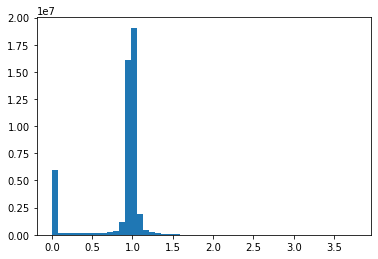

In [ ]:
import matplotlib.pyplot as plt
plt.hist(of,bins=50)
plt.show()

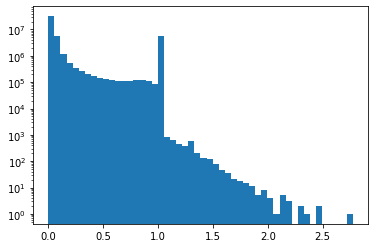

In [ ]:
delta=np.abs(of-1)
plt.hist(delta,bins=50)
plt.yscale("log",nonposy="clip")
plt.show()

In [ ]:
#some statistics processing
print(np.mean(delta))
print(np.std(delta))
print(np.max(delta))

0.17809592
0.33107832
2.773085


In [ ]:
stat_mean=np.mean(delta)
stat_sigma=np.std(delta)

In [ ]:
def corr(q):
  return np.exp(0.5*(np.abs(q-1)-stat_mean)/(stat_sigma))

In [ ]:
print(corr(np.max(delta+1)))
print(corr(1))

50.349865548992256
0.764171200435547


In [ ]:
oc=corr(oo)
oct=corr(oot)
oct-=np.mean(oc)
oct/=np.std(oct)
oc-=np.mean(oc)
oc/=np.std(oc)

In [ ]:
print(oc.shape)
print(x_train.shape)

(60000, 28, 28, 1)
(60000, 28, 28, 1)


In [ ]:
print(np.mean(oct))
print(np.std(oct))

-0.0012162012
1.0000002


**Now lets use this for anomaly infused training**

In [6]:
#at first concat this as new inputs
cc=np.concatenate((x_train,oc),axis=-1)
print(cc.shape)
cct=np.concatenate((x_test,oct),axis=-1)
print(cct.shape)

NameError: ignored

In [ ]:
modelc = keras.Sequential(
    [
        keras.Input(shape=cc.shape[1:]),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

modelc.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 26, 26, 32)        608       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1600)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)              

In [ ]:
batch_size = 128
epochs = 15

modelc.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

hc=modelc.fit(cc, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/15
422/422 [==============================] - 42s 99ms/step - loss: 0.7752 - accuracy: 0.7535 - val_loss: 0.0831 - val_accuracy: 0.9773
Epoch 2/15
422/422 [==============================] - 41s 98ms/step - loss: 0.1237 - accuracy: 0.9629 - val_loss: 0.0547 - val_accuracy: 0.9863
Epoch 3/15
422/422 [==============================] - 41s 97ms/step - loss: 0.0861 - accuracy: 0.9731 - val_loss: 0.0526 - val_accuracy: 0.9852
Epoch 4/15
422/422 [==============================] - 41s 97ms/step - loss: 0.0748 - accuracy: 0.9767 - val_loss: 0.0433 - val_accuracy: 0.9888
Epoch 5/15
422/422 [==============================] - 41s 97ms/step - loss: 0.0615 - accuracy: 0.9810 - val_loss: 0.0402 - val_accuracy: 0.9893
Epoch 6/15
422/422 [==============================] - 41s 97ms/step - loss: 0.0575 - accuracy: 0.9824 - val_loss: 0.0368 - val_accuracy: 0.9905
Epoch 7/15
422/422 [==============================] - 41s 97ms/step - loss: 0.0488 - accuracy: 0.9845 - val_loss: 0.0368 - val_accuracy:

In [ ]:
scorec = modelc.evaluate(cct, y_test, verbose=0)
print("Test loss:", scorec[0])
print("Test accuracy:", scorec[1])

Test loss: 0.022080114111304283
Test accuracy: 0.9915000200271606


In [ ]:
acn=hn.history["accuracy"]
acc=hc.history["accuracy"]
print(acn,acc)

[0.8845555782318115, 0.9658703804016113, 0.9730555415153503, 0.9769814610481262, 0.9795185327529907, 0.9813703894615173, 0.983296275138855, 0.9838888645172119, 0.9854629635810852, 0.986037015914917, 0.98674076795578, 0.9873889088630676, 0.9878703951835632, 0.9880555272102356, 0.9887592792510986] [0.88355553150177, 0.9658148288726807, 0.9740740656852722, 0.9771666526794434, 0.9800370335578918, 0.9824629426002502, 0.9842963218688965, 0.9850000143051147, 0.9860000014305115, 0.9864259362220764, 0.9863148331642151, 0.9881666898727417, 0.9876111149787903, 0.9891852140426636, 0.9896296262741089]


sadly the images are not very decisive

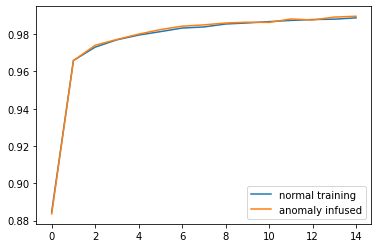

In [ ]:
plt.plot(acn,label="normal training")
plt.plot(acc,label="anomaly infused")
plt.legend()
plt.show()

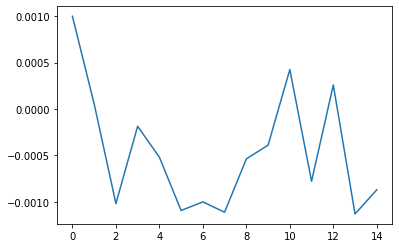

In [ ]:
plt.plot([a-b for a,b in zip(acn,acc)])
plt.show()

In [ ]:
lon=hn.history["loss"]
loc=hc.history["loss"]
print(lon,loc)

[0.38034874200820923, 0.11531105637550354, 0.08818798512220383, 0.07244840264320374, 0.066450335085392, 0.05838476121425629, 0.05405930057168007, 0.05021515488624573, 0.04822038486599922, 0.043519843369722366, 0.040937114506959915, 0.0399254746735096, 0.03727494925260544, 0.03677528351545334, 0.03456687927246094] [0.375943660736084, 0.1138433888554573, 0.08528055995702744, 0.07405813783407211, 0.06319810450077057, 0.05529489368200302, 0.051552120596170425, 0.04898780956864357, 0.04488441348075867, 0.043606337159872055, 0.04166967421770096, 0.039148569107055664, 0.037865158170461655, 0.03336763381958008, 0.03344698250293732]


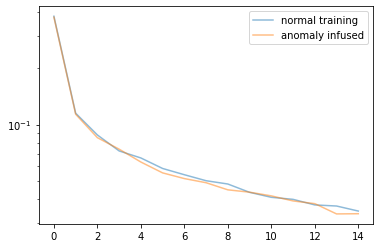

In [ ]:
plt.plot(lon,label="normal training",alpha=0.5)
plt.plot(loc,label="anomaly infused",alpha=0.5)
plt.legend()
plt.yscale("log")
plt.show()

Quick compare:

In [ ]:
print("without",score)
print("with   ",scorec)

without [0.026425588876008987, 0.9900000095367432]
with    [0.022080114111304283, 0.9915000200271606]


In [ ]:
print("both should be positive")
print("loss",score[0]-scorec[0])
print("acc",scorec[1]-score[1])

both should be positive
loss 0.004345474764704704
acc 0.0015000104904174805


Rerunning results in


both should be positive
loss -0.0016080308705568314
acc 0.00010001659393310547

both should be positive
loss 0.00017721019685268402
acc -0.000299990177154541

both should be positive
loss 0.005704481154680252
acc 0.00279998779296875

both should be positive
loss 0.0008180048316717148
acc 0.000599980354309082

both should be positive
loss 0.0008532833307981491
acc -0.00010001659393310547

both should be positive
loss 0.0019453037530183792
acc 0.0006000399589538574

both should be positive
loss 0.005755022168159485
acc 0.002200007438659668

both should be positive
loss 3.5393983125686646e-05
acc 0.00019997358322143555

both should be positive
loss -0.0015629995614290237
acc -0.000800013542175293

14/20 >0, sigma~2, so about 2 sigma significance

Having done this quick and dirty, lets do this more proffesional:

In [1]:
ll=[[0.02173512801527977,0.0233431588858366],
    [0.023866165429353714,0.02368895523250103],
    [0.0278194360435009,0.022114954888820648],
    [0.023399805650115013,0.0225818008184433],
    [0.025487083941698074,0.024633800610899925],
    [0.02620108425617218,0.0242557805031538],
    [0.027982046827673912,0.022227024659514427],
    [0.026208026334643364,0.026172632351517677],
    [0.023979149758815765,0.02554214932024479],
    [0.026425588876008987,0.022080114111304283]]

I look only at losses, because there less random. First collumn: without, second with

In [2]:
fr=len([1 for zw in ll if zw[0]>zw[1]])/len(ll)
print("fraction of improvements",fr)

fraction of improvements 0.8


In [4]:
ln=[zw[0] for zw in ll]
lc=[zw[1] for zw in ll]

import numpy as np
mn=np.mean(ln)
mc=np.mean(lc)
sn=np.std(ln)/np.sqrt(len(ln))
sc=np.std(lc)/np.sqrt(len(lc))


In [7]:
diff=mn-mc
sigma=np.sqrt(sn**2+sc**2)
print("Difference",diff)
print("With error",sigma)
print("This means a significance of")
print(diff/sigma)

Difference 0.0016463143751025214
With error 0.0007480448084267025
This means a significance of
2.200823208124485


So still about a 2 sigma improvement